In [0]:
!pip install protobuf tqdm wheel

In [0]:
!git clone --branch=stable https://github.com/bigartm/bigartm.git

In [17]:
cd bigartm

/content/bigartm/build/bigartm


In [0]:
mkdir build

In [19]:
cd build

/content/bigartm/build/bigartm/build


In [0]:
!cmake ..

In [0]:
!make

In [0]:
!pip install python/bigartm*.whl -U

In [23]:
cd ../..

/content/bigartm/build


In [0]:
!pip install pymorphy2[fast] nltk gensim

In [0]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
import string
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

In [27]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stops = set(stopwords.words('russian')) | {'gt',}
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)


def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word.replace(':', ''))[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation) for word in text.split()]
    words = [word for word in words if word]
    
    return words

In [0]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/habr_texts.txt.zip

In [30]:
!unzip habr_texts.txt.zip

Archive:  habr_texts.txt.zip
  inflating: habr_texts.txt          


Нормализация

In [0]:
texts = open('habr_texts.txt').read().splitlines()
texts = opt_normalize([tokenize(remove_tags(text.lower())) for text in texts], 30000)

Добавляем n-граммы

In [0]:
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.1, 
                           common_terms=set(stopwords.words('russian'))) 
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[texts]


Сохраняем в формате .vw

In [0]:
f = open('ngrammed_habr_texts.vw', 'w')

for i, text in enumerate(texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()


In [0]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='ngrammed_habr_texts.vw',
                                        data_format='vowpal_wabbit',
                                        target_folder='batches',
                                       batch_size=1000)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', 
                                        data_format='batches')

Создадим словарь. Фильтруем слишком редкие и слишком частотные слова (увеличил min_df)

In [0]:
dictionary = artm.Dictionary()

In [78]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=20, max_df=2000)

artm.Dictionary(name=396cbc2c-4c16-49f3-937f-8bf1dfa19586, num_entries=7622)

In [0]:
dictionary.save_text('dict.txt')

Файл со словарем просто смотрел и не редактировал. Мне показалось, что в нем нормальные слова. Можно убрать какие-то числа, даты и слова из кода, но они тоже могут быть важны в тематическом моделировании

In [0]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [0]:
model_artm.initialize(dictionary=dictionary)

In [0]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

In [0]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [0]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [0]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [0]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.658 ARTM)
Sparsity Theta: 0.106 (ARTM)
Kernel contrast: 0.223 (ARTM)
Kernel purity: 0.201 (ARTM)
Perplexity: 374.264 (ARTM)


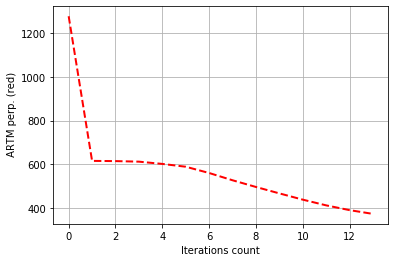

In [89]:
print_measures(model_artm)

За счет более высокого уровня min df вырос показатель Perplexity, но возможно могли потеряться значимые для тем редкие слова.

In [0]:
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError:
        continue

Тема 19 навевает мысли о том, что стоит уменьшить верхнюю границу частотности слов при создании словаря. 
topic_19: 
to
the
in
a
be
you
that
for
on
are
Уменьшим также нижнюю границу с 20 до 15. Еще попробуем уменьшить количество тем

In [116]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=15, max_df=1500)


artm.Dictionary(name=000ac00b-d3ca-4715-8bbb-5cda653e2565, num_entries=8957)

In [0]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(50)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [0]:
model_artm.initialize(dictionary=dictionary)

In [0]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

In [0]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [0]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [0]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [0]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.492 ARTM)
Sparsity Theta: 0.032 (ARTM)
Kernel contrast: 0.244 (ARTM)
Kernel purity: 0.357 (ARTM)
Perplexity: 298.712 (ARTM)


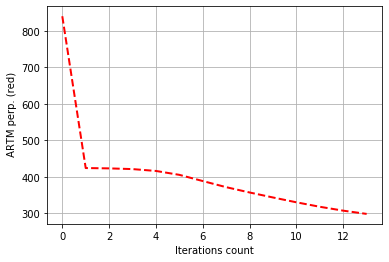

In [124]:
print_measures(model_artm)

На первый взгляд, perplexity стало лучше. Но надо будет посмотреть и на сами темы.

In [0]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: 
        continue

Какие-то темы внушают оптимизм:
topic_24: 
космический
станция
аппарат
двигатель
спутник
километр
поверхность
–
учёный
испытание, topic_35: 
диск
сервер
т.е
запись
файл
кластер
приложение
память
хранение
запрос
Но далеко не все. Стоит попробовать изменить что-нибудь еще. 

В этот раз пусть будет золотая середина - 100 тем, поменяем значения tau у регуляризаторов. Словарь будем использовать тот же(min_df=15, max_df=1500)

In [0]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=15, max_df=1500)

In [0]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(100)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [0]:
model_artm.initialize(dictionary=dictionary)

In [0]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

In [0]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [0]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [0]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [0]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(15):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.4))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.2))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.604 ARTM)
Sparsity Theta: 0.072 (ARTM)
Kernel contrast: 0.244 (ARTM)
Kernel purity: 0.305 (ARTM)
Perplexity: 267.128 (ARTM)


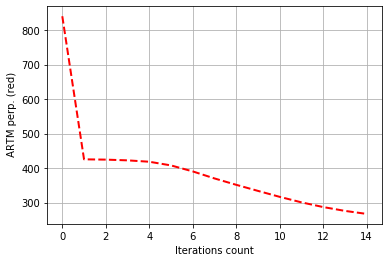

In [147]:
print_measures(model_artm)

Perplexity снова улучшилась

In [0]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: 
        continue

В темах проскальзывают прочерки "-". Но выглядят они уже неплохо, хоть и встречаются лишние слова. На данный момент это наилучший результат. Вот некоторые из полученных тем:

1)кнопка
символ
нажать
блок
значение
иначе
клавиатура
шрифт
нажатие
текст

2) клетка
мозг
движение
рука
тело
ген
глаз
животное
кожа
организм

3) доклад
конференция
–
тема
участник
разработчик
выступление
слайд
спикер
рассказать


В лучшей версии значения tfidf следующие: min_df=15, max_df=1500. Количество тем - 100, были изменены значения постепенного увеличения резуляризаторов phi_tau*0.4 и theta_tau*0.2 в течение 10 итераций. Выше можно увидеть график обучения данной модели. 